<a href="https://colab.research.google.com/github/coleb9/Time-Series-Project/blob/tcn_model/Time_Series_Project_Seasonarity_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Project — Electricity Load & Renewable Forecasting

This notebook contains the full workflow for our time series forecasting project:

- Loading and preparing the OPSD dataset
- Feature engineering
- Creating sliding windows
- Building LSTM, GRU, and Transformer models
- Training and evaluating models
- Comparing performance


# Pre-Processing

In [1]:
from google.colab import files
uploaded = files.upload()

Saving time_series_60min_singleindex.csv to time_series_60min_singleindex.csv


In [2]:
import pandas as pd

df = pd.read_csv("time_series_60min_singleindex.csv")

# Select only the German columns we need
columns = [
    "utc_timestamp",
    "DE_load_actual_entsoe_transparency",
    "DE_wind_onshore_generation_actual",
    "DE_solar_generation_actual"
]

df = df[columns]
df.head()


,utc_timestamp,DE_load_actual_entsoe_transparency,DE_wind_onshore_generation_actual,DE_solar_generation_actual
0,2014-12-31T23:00:00Z,NaN,NaN,NaN
1,2015-01-01T00:00:00Z,41151.0,8336.0,NaN
2,2015-01-01T01:00:00Z,40135.0,8540.0,NaN
3,2015-01-01T02:00:00Z,39106.0,8552.0,NaN
4,2015-01-01T03:00:00Z,38765.0,8643.0,NaN


In [3]:
# Convert timestamp to proper datetime format
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])

# Set it as the index
df = df.set_index('utc_timestamp')

# Sort by time just to be safe
df = df.sort_index()

df.head()


,DE_load_actual_entsoe_transparency,DE_wind_onshore_generation_actual,DE_solar_generation_actual
utc_timestamp,,,
2014-12-31 23:00:00+00:00,NaN,NaN,NaN
2015-01-01 00:00:00+00:00,41151.0,8336.0,NaN
2015-01-01 01:00:00+00:00,40135.0,8540.0,NaN
2015-01-01 02:00:00+00:00,39106.0,8552.0,NaN
2015-01-01 03:00:00+00:00,38765.0,8643.0,NaN


In [4]:
# Check how many missing values exist
df.isna().sum()

# Ensure all numeric columns are actually numeric (required for interpolation)
df = df.apply(pd.to_numeric, errors='coerce')

# Interpolate missing values based on time
df = df.interpolate(method='time')

# Fill any NaNs that remain at the very start or end (edges)
df = df.ffill().bfill()

# Confirm everything is filled now
df.isna().sum()


,0
DE_load_actual_entsoe_transparency,0
DE_wind_onshore_generation_actual,0
DE_solar_generation_actual,0


In [5]:
# Create time-based features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek    # Monday=0, Sunday=6
df['month'] = df.index.month

df.head()

,DE_load_actual_entsoe_transparency,DE_wind_onshore_generation_actual,DE_solar_generation_actual,hour,day_of_week,month
utc_timestamp,,,,,,
2014-12-31 23:00:00+00:00,41151.0,8336.0,71.0,23,2,12
2015-01-01 00:00:00+00:00,41151.0,8336.0,71.0,0,3,1
2015-01-01 01:00:00+00:00,40135.0,8540.0,71.0,1,3,1
2015-01-01 02:00:00+00:00,39106.0,8552.0,71.0,2,3,1
2015-01-01 03:00:00+00:00,38765.0,8643.0,71.0,3,3,1


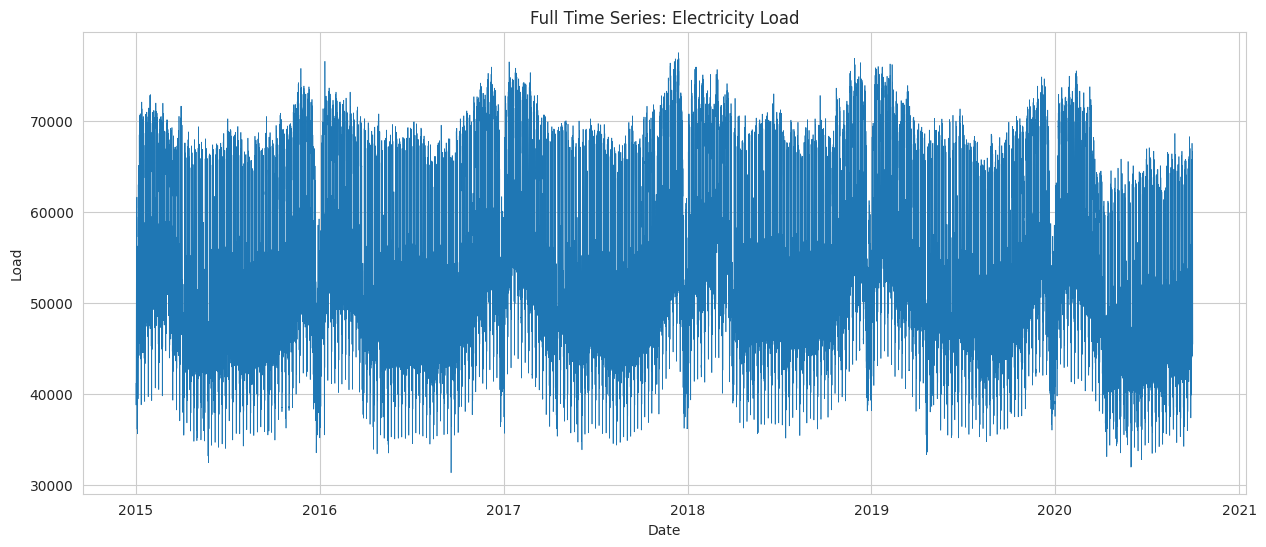

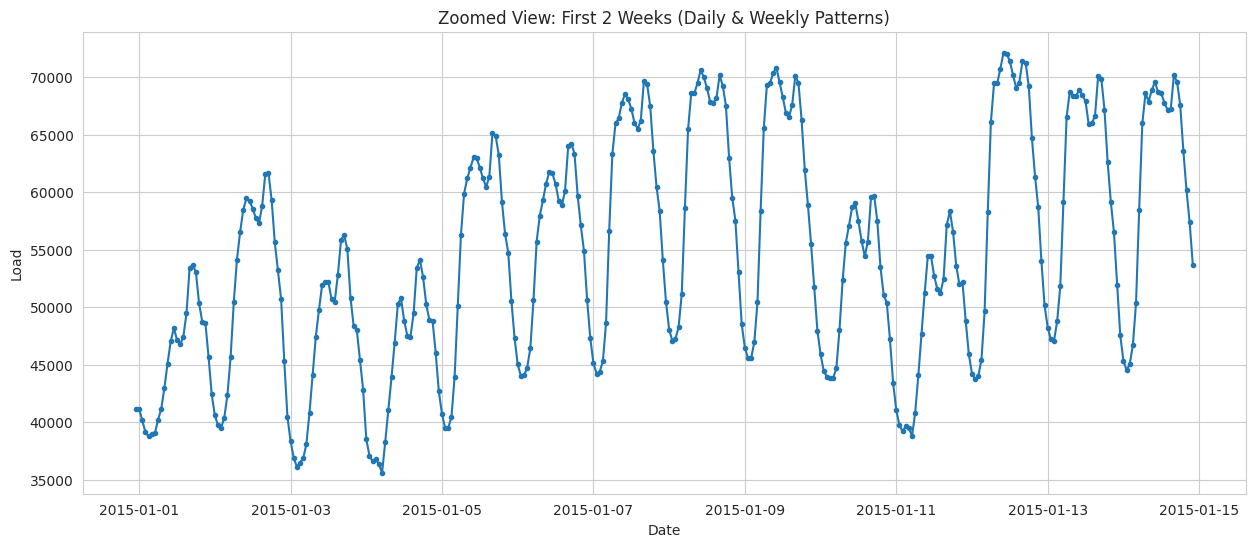

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")

# Plot 1: Trend over the full duration
plt.figure(figsize=(15, 6))
plt.plot(df.index, df[target_col], label='Full History', linewidth=0.5)
plt.title('Full Time Series: Electricity Load')
plt.xlabel('Date')
plt.ylabel('Load')
plt.show()

# Plot 2: Zoom into 2 weeks to see Daily and Weekly Seasonality
# 24 hours * 14 days = 336 data points
plt.figure(figsize=(15, 6))
plt.plot(df.index[:336], df[target_col][:336], marker='.')
plt.title('Zoomed View: First 2 Weeks (Daily & Weekly Patterns)')
plt.xlabel('Date')
plt.ylabel('Load')
plt.grid(True)
plt.show()

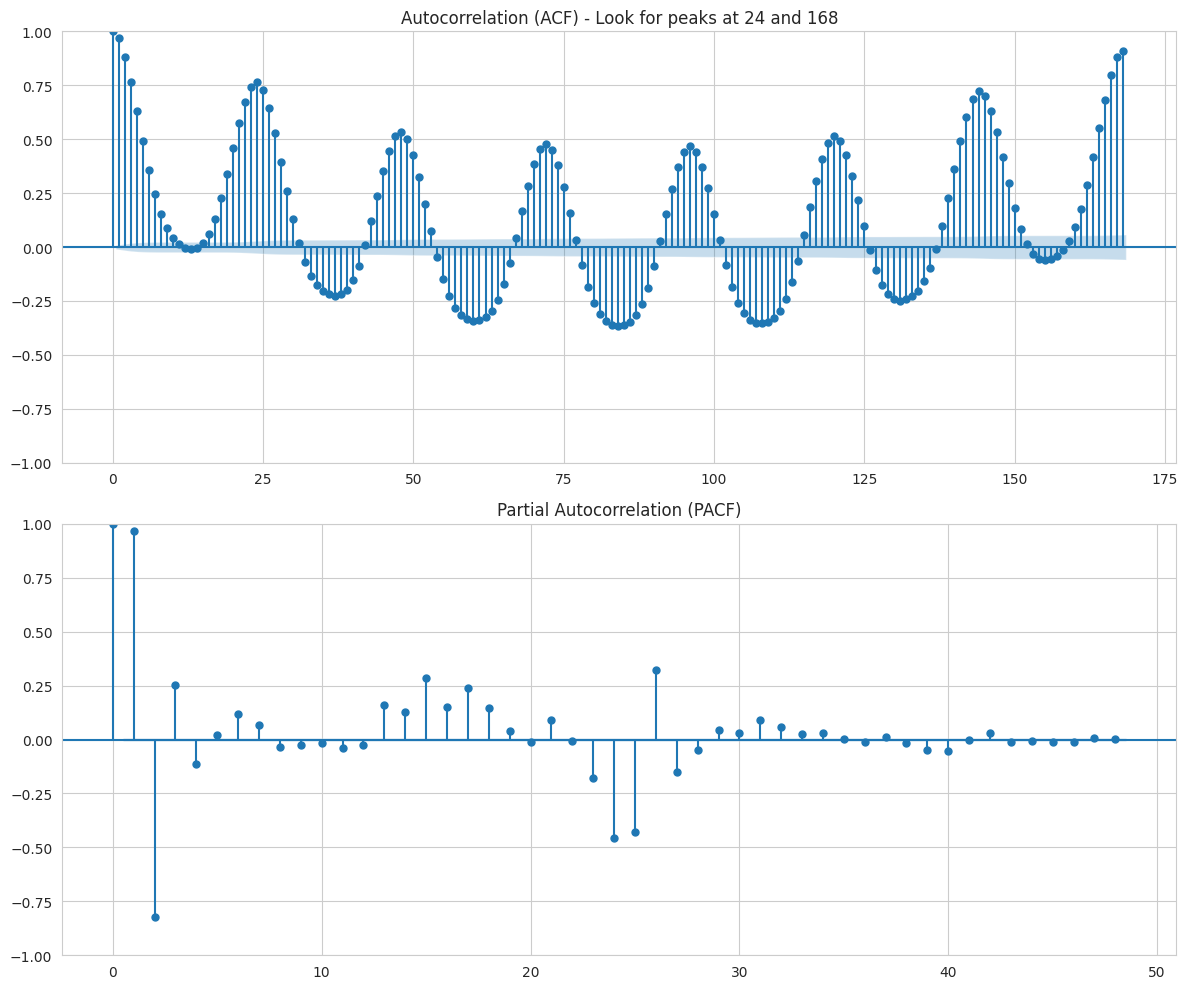

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot ACF
# We use lags=168 (24h * 7 days) to check for weekly patterns
plot_acf(df[target_col], lags=168, ax=ax1, title="Autocorrelation (ACF) - Look for peaks at 24 and 168")

# Plot PACF
# PACF shows direct correlation removing intermediate effects
# We use lags=48 to check immediate autoregressive dependance
plot_pacf(df[target_col], lags=48, ax=ax2, method='ywm', title="Partial Autocorrelation (PACF)")

plt.tight_layout()
plt.show()

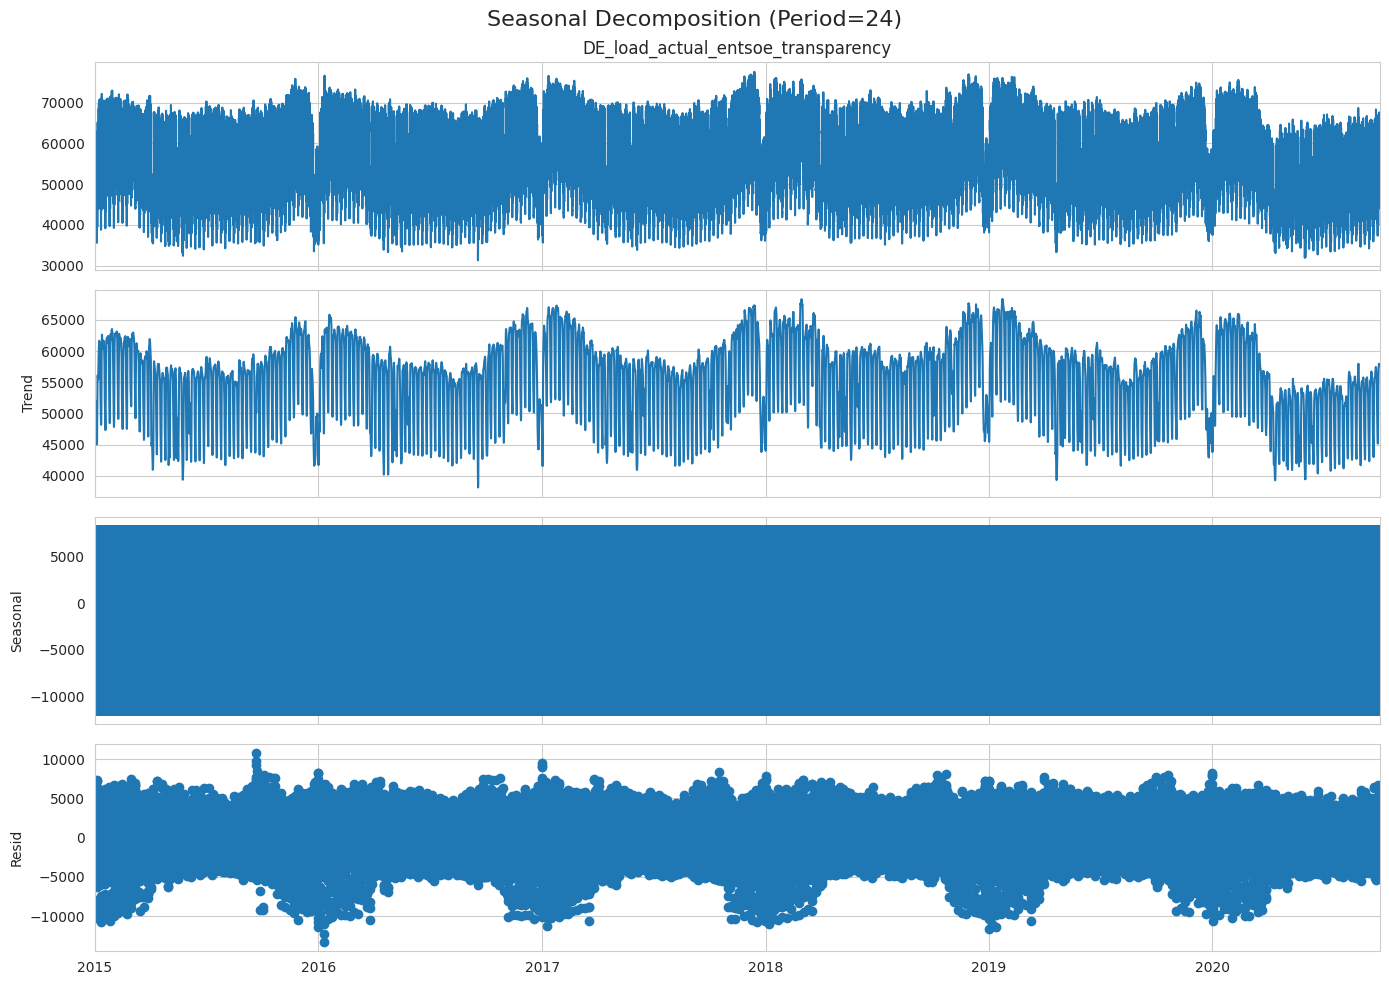

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the series
# We set period=24 because we expect a daily cycle in hourly data
decomposition = seasonal_decompose(df[target_col], model='additive', period=24)

# Plot the components
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.suptitle('Seasonal Decomposition (Period=24)', fontsize=16)
plt.tight_layout()
plt.show()

In [11]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
    print(f"Results of Dickey-Fuller Test on {target_col}:")
    dftest = adfuller(dataset, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    if dftest[1] <= 0.05:
        print("\nConclusion: Data is Stationary (Reject Null Hypothesis)")
    else:
        print("\nConclusion: Data is Non-Stationary (Fail to Reject Null Hypothesis)")

# Run the test
adf_test(df[target_col])

Results of Dickey-Fuller Test on DE_load_actual_entsoe_transparency:
Test Statistic                   -21.694830
p-value                            0.000000
#Lags Used                        57.000000
Number of Observations Used    50343.000000
Critical Value (1%)               -3.430480
Critical Value (5%)               -2.861597
Critical Value (10%)              -2.566801
dtype: float64

Conclusion: Data is Stationary (Reject Null Hypothesis)


### Interpreting Seasonarity Results
#### Visual & Component Analysis:
The workflow begins with visual inspection and Seasonal Decomposition to separate the time series into Trend, Seasonal, and Residual components. This helps identify the expected Daily (24-step) and Weekly repeating patterns.
#### Correlation Verification (ACF/PACF):
The code implements Autocorrelation and Partial Autocorrelation plots to identify significant lags. High peaks at Lag 24 (daily) and Lag 168 (weekly) verify the necessity of the engineered hour and day_of_week features.
#### Stationarity Testing:
The Augmented Dickey-Fuller (ADF) test is used to determine if the data is stationary (p-value $\le$ 0.05). If the data is found to be non-stationary (common in electricity demand due to trends), differencing or transformations are recommended before model training.
#### Model Input Optimization:
While the current sliding window size of 24 captures the daily cycle, the analysis suggests increasing the window (e.g., to 48 or 168) if the ACF shows strong weekly correlations, ensuring the LSTM/Transformer model receives sufficient historical.

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Create a scaler for all columns
scaler = MinMaxScaler()

# Fit and transform the DataFrame
scaled_values = scaler.fit_transform(df)

# Convert back to a DataFrame with the same index and column names
df_scaled = pd.DataFrame(scaled_values, index=df.index, columns=df.columns)

df_scaled.head()


,DE_load_actual_entsoe_transparency,DE_wind_onshore_generation_actual,DE_solar_generation_actual,hour,day_of_week,month
utc_timestamp,,,,,,
2014-12-31 23:00:00+00:00,0.212880,0.202225,0.002155,1.000000,0.333333,1.0
2015-01-01 00:00:00+00:00,0.212880,0.202225,0.002155,0.000000,0.500000,0.0
2015-01-01 01:00:00+00:00,0.190909,0.207245,0.002155,0.043478,0.500000,0.0
2015-01-01 02:00:00+00:00,0.168656,0.207541,0.002155,0.086957,0.500000,0.0
2015-01-01 03:00:00+00:00,0.161282,0.209780,0.002155,0.130435,0.500000,0.0


In [7]:
import numpy as np

# We will predict this column:
target_col = "DE_load_actual_entsoe_transparency"

# How many past hours to use
window_size = 24

data = df_scaled.copy()

X_list = []
y_list = []

target_idx = data.columns.get_loc(target_col)

for i in range(len(data) - window_size):
    # past 24 hours of all features
    X_list.append(data.iloc[i : i + window_size].values)
    # load value at the next hour
    y_list.append(data.iloc[i + window_size, target_idx])

X = np.array(X_list)
y = np.array(y_list)

X.shape, y.shape


((50377, 24, 6), (50377,))